In [13]:
# Import modules

%matplotlib notebook

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from graph_model import CallBacks, DataGenerator, GraphNet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Define the data directories

model_name = "max-aggregate2_dropout=0.15+Gaussian"

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")

# Data preparation

In [3]:
# Fix random seed for reproducibility
np.random.seed(0)

# Data ranges (min/max)
minlatitude = 32
maxlatitude = 36
minlongitude = -120
maxlongitude = -116
maxdepth = 30e3
minmag = 3
maxmag = 6

# Fraction of the data to be used in training
split = 0.8

As part of the data preparation process, we scale the data within the range of $\pm 1$, and split the data set into a training set and a validation set.

1377
0.23999678936208627 50.291751151835314


<IPython.core.display.Javascript object>


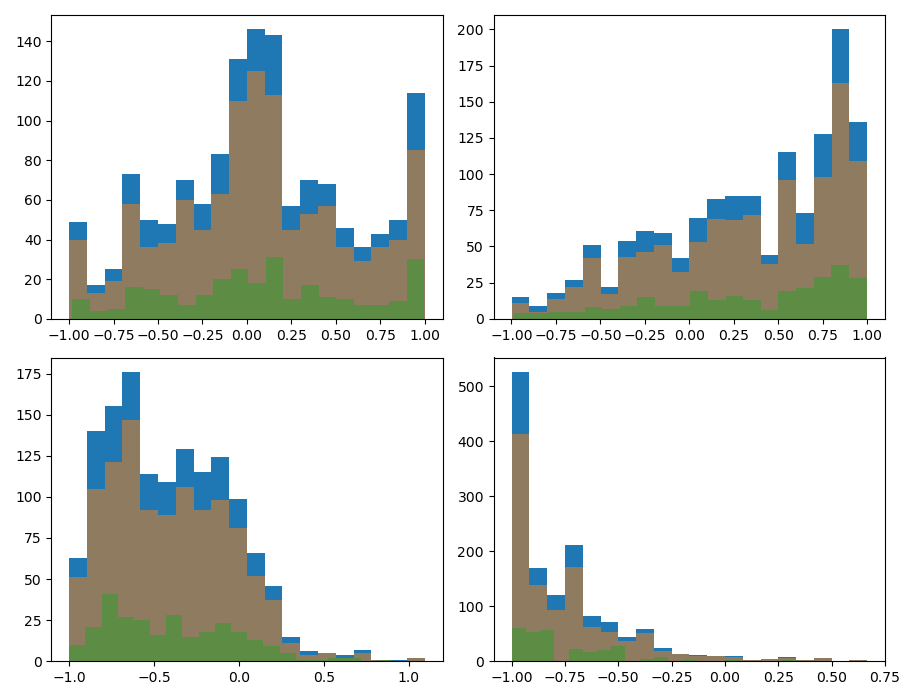

In [4]:
# Get the event catalogue
catalogue = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))[["lat", "lon", "depth", "mag"]]

# Check which events have data
for i, event in catalogue.iterrows():
    # Event data file
    cat_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # If file not exists: remove event from catalogue
    if not os.path.isfile(cat_file):
        catalogue.drop(index=i, inplace=True)

# Print number of events
print(len(catalogue))        

# Event identifiers
ids = catalogue.index.values
# Uniform weights
weights = np.ones((len(ids), 1))
# Event lat/lon/depth/magnitude
catalogue = catalogue.values

# Scale data
catalogue[:, 0] = (catalogue[:, 0] - minlatitude) / (maxlatitude - minlatitude)
catalogue[:, 1] = (catalogue[:, 1] - minlongitude) / (maxlongitude - minlongitude)
catalogue[:, 2] = catalogue[:, 2] / maxdepth
catalogue[:, 3] = (catalogue[:, 3] - minmag) / (maxmag - minmag)

catalogue = (catalogue - 0.5) * 2

# Concatenate identifiers and weights to event data
catalogue = np.concatenate([ids.reshape(-1, 1), weights.reshape(-1, 1), catalogue], axis=1)

# Randomly split events into train and validation sets
inds = np.arange(catalogue.shape[0])
np.random.shuffle(inds)
N_split = int(split * catalogue.shape[0])

train_inds = inds[:N_split]
test_inds = inds[N_split:]

# Split catalogue
train_catalogue = catalogue[train_inds]
test_catalogue = catalogue[test_inds]

# Check data distributions to ensure that train and validation sets are similar!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axes = axes.ravel()

for i in range(4):
    ax = axes[i]
    ax.hist(catalogue[:, i+2], bins=20, density=False)
    ax.hist(train_catalogue[:, i+2], bins=20, alpha=0.5, density=False)
    ax.hist(test_catalogue[:, i+2], bins=20, alpha=0.5, density=False)

plt.tight_layout()    
plt.show()

In [5]:
# Read seismic station information
stations = pd.read_csv(os.path.join(data_dir, "stations.csv"))[["code", "lat", "lon"]]
# Scale station geographic locations
stations["lat"] = ((stations["lat"] - minlatitude) / (maxlatitude - minlatitude) - 0.5) * 2
stations["lon"] = ((stations["lon"] - minlongitude) / (maxlongitude - minlongitude) - 0.5) * 2

In [6]:
# Open the event-station lookup file
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")

with open(lookup_file, "rb") as f:
    lookup = pickle.load(f)

In [8]:
# Number of stations per sample
N_sub = 50
# Number of time sample points
N_t = 2048

# Instantiate train data generator
train_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=train_catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
)

# Instantiate validation data generator
test_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=test_catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
)

# Model construction

In [21]:
""" Define Tensorflow/Keras callbacks """

# Tensorboard log directory
logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)

# Save model directory
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

# Best and last model save files
savefile_best = "best-model.h5"
savefile_last = "last-model.h5"

# Instantiate callbacks
tensorboard_callback = CallBacks.tensorboard(logdir)
checkpoint_callback_best = CallBacks.checkpoint(os.path.join(savedir, savefile_best), best=True)
checkpoint_callback_last = CallBacks.checkpoint(os.path.join(savedir, savefile_last), best=False)

In [22]:
# Instantiate Graph Neural Network
graph = GraphNet()
# Overwrite default model parameters
params = {
    "N_t": N_t,
    "dropout_rate": 0.15,
    "activation": "relu",
}
# Set parameters
graph.set_params(params)
# Construct a graph model
model = graph.construct()
# Print out a summary
model.summary()
# Output model summary to a PNG image (if possible)
plot_model(model, show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50, 2048, 3) 0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 50, 2048, 4)  64          input_10[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 50, 2048, 4)  0           conv2d_51[0][0]                  
__________________________________________________________________________________________________
gaussian_dropout_54 (GaussianDr (None, 50, 2048, 4)  0           activation_51[0][0]              
____________________________________________________________________________________________

In [23]:
# Compile the model with an ADAM optimiser and mean absolute error loss function
model.compile(
    optimizer=Adam(learning_rate=model.LR),
    loss="mean_absolute_error",
)

# Train the model for 500 epochs
model.fit(
    x=train_generator,
    validation_data=test_generator,
    callbacks=[tensorboard_callback, checkpoint_callback_best, checkpoint_callback_last],
    verbose=2, epochs=500,
)

Train for 34 steps, validate for 8 steps
Epoch 1/500
34/34 - 9s - loss: 0.4707 - val_loss: 0.4283
Epoch 2/500
34/34 - 7s - loss: 0.3941 - val_loss: 0.3638
Epoch 3/500
34/34 - 7s - loss: 0.3569 - val_loss: 0.3420
Epoch 4/500
34/34 - 8s - loss: 0.3446 - val_loss: 0.3429
Epoch 5/500
34/34 - 8s - loss: 0.3404 - val_loss: 0.3389
Epoch 6/500
34/34 - 7s - loss: 0.3372 - val_loss: 0.3417
Epoch 7/500
34/34 - 7s - loss: 0.3353 - val_loss: 0.3373
Epoch 8/500
34/34 - 7s - loss: 0.3353 - val_loss: 0.3318
Epoch 9/500
34/34 - 7s - loss: 0.3315 - val_loss: 0.3265
Epoch 10/500
34/34 - 7s - loss: 0.3257 - val_loss: 0.3227
Epoch 11/500
34/34 - 8s - loss: 0.3191 - val_loss: 0.3204
Epoch 12/500
34/34 - 7s - loss: 0.3122 - val_loss: 0.3077
Epoch 13/500
34/34 - 7s - loss: 0.3016 - val_loss: 0.2999
Epoch 14/500
34/34 - 7s - loss: 0.2935 - val_loss: 0.2855
Epoch 15/500
34/34 - 7s - loss: 0.2881 - val_loss: 0.2771
Epoch 16/500
34/34 - 8s - loss: 0.2774 - val_loss: 0.2673
Epoch 17/500
34/34 - 7s - loss: 0.2701 -

Epoch 141/500
34/34 - 8s - loss: 0.1428 - val_loss: 0.1383
Epoch 142/500
34/34 - 7s - loss: 0.1408 - val_loss: 0.1358
Epoch 143/500
34/34 - 7s - loss: 0.1398 - val_loss: 0.1347
Epoch 144/500
34/34 - 7s - loss: 0.1434 - val_loss: 0.1363
Epoch 145/500
34/34 - 7s - loss: 0.1395 - val_loss: 0.1337
Epoch 146/500
34/34 - 7s - loss: 0.1394 - val_loss: 0.1333
Epoch 147/500
34/34 - 8s - loss: 0.1406 - val_loss: 0.1358
Epoch 148/500
34/34 - 7s - loss: 0.1410 - val_loss: 0.1350
Epoch 149/500
34/34 - 7s - loss: 0.1404 - val_loss: 0.1340
Epoch 150/500
34/34 - 8s - loss: 0.1372 - val_loss: 0.1327
Epoch 151/500
34/34 - 8s - loss: 0.1387 - val_loss: 0.1338
Epoch 152/500
34/34 - 7s - loss: 0.1388 - val_loss: 0.1334
Epoch 153/500
34/34 - 8s - loss: 0.1383 - val_loss: 0.1350
Epoch 154/500
34/34 - 7s - loss: 0.1365 - val_loss: 0.1378
Epoch 155/500
34/34 - 8s - loss: 0.1392 - val_loss: 0.1303
Epoch 156/500
34/34 - 7s - loss: 0.1359 - val_loss: 0.1344
Epoch 157/500
34/34 - 7s - loss: 0.1375 - val_loss: 0.13

Epoch 280/500
34/34 - 7s - loss: 0.1229 - val_loss: 0.1222
Epoch 281/500
34/34 - 7s - loss: 0.1239 - val_loss: 0.1207
Epoch 282/500
34/34 - 7s - loss: 0.1209 - val_loss: 0.1229
Epoch 283/500
34/34 - 7s - loss: 0.1231 - val_loss: 0.1201
Epoch 284/500
34/34 - 7s - loss: 0.1225 - val_loss: 0.1225
Epoch 285/500
34/34 - 8s - loss: 0.1245 - val_loss: 0.1189
Epoch 286/500
34/34 - 7s - loss: 0.1229 - val_loss: 0.1219
Epoch 287/500
34/34 - 7s - loss: 0.1216 - val_loss: 0.1181
Epoch 288/500
34/34 - 7s - loss: 0.1225 - val_loss: 0.1202
Epoch 289/500
34/34 - 7s - loss: 0.1235 - val_loss: 0.1216
Epoch 290/500
34/34 - 7s - loss: 0.1212 - val_loss: 0.1209
Epoch 291/500
34/34 - 7s - loss: 0.1204 - val_loss: 0.1204
Epoch 292/500
34/34 - 7s - loss: 0.1244 - val_loss: 0.1209
Epoch 293/500
34/34 - 7s - loss: 0.1230 - val_loss: 0.1210
Epoch 294/500
34/34 - 8s - loss: 0.1226 - val_loss: 0.1216
Epoch 295/500
34/34 - 7s - loss: 0.1208 - val_loss: 0.1205
Epoch 296/500
34/34 - 7s - loss: 0.1214 - val_loss: 0.12

Epoch 419/500
34/34 - 7s - loss: 0.1159 - val_loss: 0.1152
Epoch 420/500
34/34 - 8s - loss: 0.1154 - val_loss: 0.1148
Epoch 421/500
34/34 - 7s - loss: 0.1150 - val_loss: 0.1158
Epoch 422/500
34/34 - 7s - loss: 0.1153 - val_loss: 0.1150
Epoch 423/500
34/34 - 7s - loss: 0.1149 - val_loss: 0.1172
Epoch 424/500
34/34 - 7s - loss: 0.1128 - val_loss: 0.1143
Epoch 425/500
34/34 - 7s - loss: 0.1149 - val_loss: 0.1134
Epoch 426/500
34/34 - 7s - loss: 0.1162 - val_loss: 0.1130
Epoch 427/500
34/34 - 7s - loss: 0.1151 - val_loss: 0.1161
Epoch 428/500
34/34 - 7s - loss: 0.1147 - val_loss: 0.1153
Epoch 429/500
34/34 - 7s - loss: 0.1170 - val_loss: 0.1166
Epoch 430/500
34/34 - 7s - loss: 0.1155 - val_loss: 0.1140
Epoch 431/500
34/34 - 7s - loss: 0.1147 - val_loss: 0.1158
Epoch 432/500
34/34 - 7s - loss: 0.1149 - val_loss: 0.1160
Epoch 433/500
34/34 - 7s - loss: 0.1143 - val_loss: 0.1142
Epoch 434/500
34/34 - 7s - loss: 0.1139 - val_loss: 0.1145
Epoch 435/500
34/34 - 7s - loss: 0.1147 - val_loss: 0.11